## Experimenting with Vector Variables and Parameters in MTK
**Scenario 1**
2 patches, 1 connecting corridor, everyone wants to go from patch 1 to patch 2.

**Scenario 2**
2 patches, 2 connecting corridors, everyone wants to go from patch 1 to patch 2.

Notebook outline:
1. Non-vector representation of scenario 1 in `DifferentialEquations.jl`
2. Non-vector representation of scenario 1 in `DifferentialEquations.jl`
3. Vector representation of scenario 2 in `DifferentialEquations.jl`
4. Attempt at vector representation of scenario 1 in `ModelingToolkit.jl`

## 1. DifferentialEquations.jl (Scenario 1)
Non-vector representation. 2 patches, 1 corridor, everyone wants to go from patch 1 to patch 2.

In [6]:
using DifferentialEquations
using Plots
using LinearAlgebra
using LaTeXStrings
using Roots
using Interpolations
using RecursiveArrayTools
using QuadGK
using Printf
using CSV
using DataFrames

In [11]:
function traffic_flow_demo!(dN, N, p, t)
    #=
        Returns (change in place)
            - dN: array-like, size (6,)
                    population values at next time step
        Arguments
            - dN: array-like, size (6,)
                    population values at next time step
            - N: array-like, size (6,)
                    population values at current time step
                    N = [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
            - p: array-like, size (6,)
                    parameters
                    p = [α₁, α₂, β₁, β₂, p1_out, p2_out]
    =#
    P¹ = N[1]      # population in patch 1
    P² = N[2]      # population in patch 2
    C¹₁₂ = N[3]    # population in corridor 1, lane from patch 1 to patch 2
    C¹₂₁ = N[4]    # population in corridor 1, lane from patch 2 to patch 1

    α₁ = p[1]       # tolerance for congestion, originators in patch 1
    α₂ = p[2]       # tolerance for congestion, originators in patch 2
    β₁ = p[3]       # inverse road capacity, corridor 1
    p1_out = p[4]   # overall demand for leaving P1
    p2_out = p[5]   # overall demand for leaving P2

    # Fluxes
    F₁ᶜ¹ = p1_out * exp(-β₁ * α₁ * C¹₁₂) * P¹   # flux from patch 1 into corridor 1 (implicitly heading towards patch 2)
    F₂ᶜ¹ = p2_out * exp(-β₁ * α₂ * C¹₂₁) * P²   # flux from patch 2 into corridor 1 (implicitly heading towards patch 1)

    Fc₁¹ = exp(-β₁ * C¹₂₁) * C¹₂₁     # flux from corridor 1 into patch 1 (implicitly lane from p2 to p1)
    Fc₁² = exp(-β₁ * C¹₁₂) * C¹₁₂     # flux from corridor 1 into patch 2 (implicitly lane from p1 to p2)
    
    # Net changes to state variables
    dN[1] = Fc₁¹ - F₁ᶜ¹ # change in population Patch 1
    dN[2] = Fc₁² - F₂ᶜ¹ # change in population Patch 2
    dN[3] = F₁ᶜ¹ - Fc₁² # change in population of Corridor 1 lane from p1 to p2
    dN[4] = F₂ᶜ¹ - Fc₁¹ # change in population of Corridor 1 lane from p2 to p1

end

traffic_flow_demo! (generic function with 1 method)

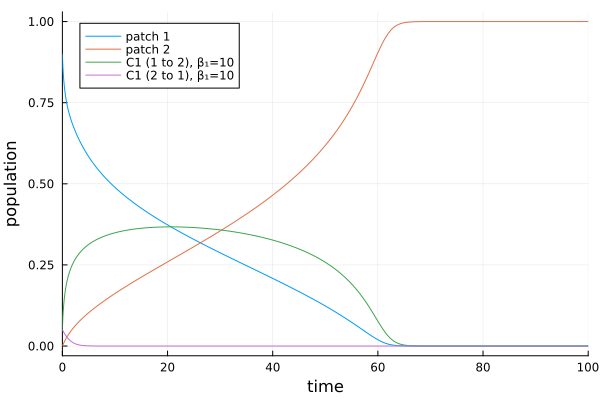

In [16]:
# Choose parameters
α₁ = 1.0 #0.7
α₂ = 1.0 #0.9
β₁ = 10  #100 # 15, 15
p1_out = 1
p2_out = 0
p = [α₁, α₂, β₁, p1_out, p2_out]

# Solve diff eq
t_end = 100.0
N0 = [0.9; 0; 0.05; 0.05]                              # set initial conditions: [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
prob = ODEProblem(traffic_flow_demo!, N0, (0.0, t_end), p)   # create problem (system of diff eqs)
sol = solve(prob, Tsit5(), saveat=0.05)                                     # solve problem

# Plot each population over time
plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
plot!(sol, idxs = (0,2), xlabel="time", ylabel="population", label="patch 2")
plot!(sol, idxs = (0,3), xlabel="time", ylabel="population", label="C1 (1 to 2), β₁=$β₁")
plot!(sol, idxs = (0,4), xlabel="time", ylabel="population", label="C1 (2 to 1), β₁=$β₁")

## 2. ModelingToolkit.jl (Scenario 1)
Non-vector representation. 2 patches, 1 connecting corridor, everyone wants to go from patch 1 to patch 2.

In [2]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
using OrdinaryDiffEq
using Plots

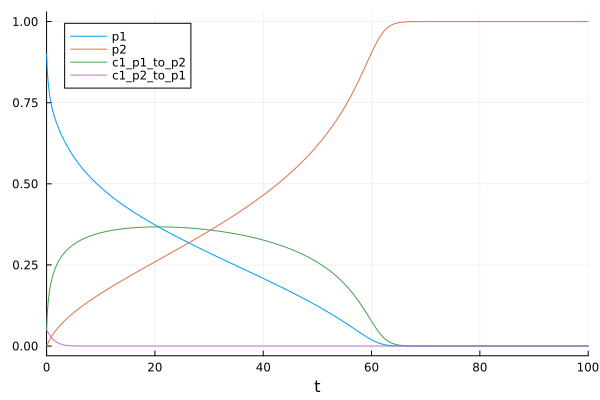

In [3]:
@mtkmodel FOL begin
    @parameters begin
        d_p1 = 1.0
        d_p2 = 0.0
        alpha_1 = 1.0 # parameters and their values
        alpha_2 = 1.0
        beta_c1 = 10
    end
    @variables begin
        p1(t) = 0.9 # dependent variables and their initial conditions
        p2(t) = 0.0
        c1_p1_to_p2(t) = 0.05
        c1_p2_to_p1(t) = 0.05
        F_c1_to_p1(t)
        F_c1_to_p2(t)
        F_p1_to_c1(t)
        F_p2_to_c1(t)
    end
    @equations begin
        # Leaving functions
        F_p1_to_c1 ~ d_p1 * exp(- (alpha_1 * beta_c1) * c1_p1_to_p2) * p1
        F_p2_to_c1 ~ d_p2 * exp(- (alpha_2 * beta_c1) * c1_p2_to_p1) * p2

        # Arriving functions
        F_c1_to_p1 ~ exp(-beta_c1 * c1_p2_to_p1) * c1_p2_to_p1
        F_c1_to_p2 ~ exp(-beta_c1 * c1_p1_to_p2) * c1_p1_to_p2

        # Main equations
        D(p1) ~ F_c1_to_p1 - F_p1_to_c1
        D(p2) ~ F_c1_to_p2 - F_p2_to_c1
        D(c1_p1_to_p2) ~ F_p1_to_c1 - F_c1_to_p2
        D(c1_p2_to_p1) ~ F_p2_to_c1 - F_c1_to_p1
    end
end

@mtkbuild fol = FOL()
prob = ODEProblem(fol, [], (0.0, 100.0), [])
plot(solve(prob)) # How to quickly add text boxes for parameters?

## 3. DifferentialEquations.jl (Scenario 2)
Vector representation of Scenario 2. 2 patches, 2 connecting corridor, everyone wants to go from patch 1 to patch 2.

In [4]:
function sys_of_eqs!(dN, N, p, t)
    #=
        Returns (change in place)
            - dN: VectorOfArrays, (P, C)
                    population values at next time step
        Arguments
            - dN: VectorOfArrays, (P, C)
                    population values at next time step
            - N: VectorOfArrays, (P, C)
                    population values at current time step
                    N = [P¹, P², C¹₁₂, C¹₂₁, C²₁₂, C²₂₁]
            - p: VectorOfArrays, size (3, ...)
                    parameters
                    p = [αᵢ, βₖ, pi_out]
    =#
    
    # get variables
    P = N.x[1]     # 1D array with n elements
    C = N.x[2]     # n x n x k array
    C_map = C .!= 0.0 # should this be passed in separately, or can I trust it to recalculate each time?
    n = length(P)  # number of patches
    k = size(C)[3] # number of "layers" of corridors (max number of corridors per pair)

    C1_p1_to_p1=C[1,1,1]; C1_p1_to_p2=C[1,2,1]; C1_p2_to_p1=C[2,1,1]; C1_p2_to_p2=C[2,2,1]
    C2_p1_to_p1=C[1,1,2]; C2_p1_to_p2=C[1,2,2]; C2_p2_to_p1=C[2,1,2]; C2_p2_to_p2=C[2,2,2]
    println("____________")
    println("C1_p1_to_p2:$C1_p1_to_p2")
    println("C1_p2_to_p1:$C1_p2_to_p1")
    println("C2_p1_to_p2:$C2_p1_to_p2")
    println("C2_p2_to_p1:$C2_p2_to_p1")

    # get parameters
    α = p[1] # α[i] is aversion to congestion for travelers in patch i
    β = p[2] # β[i,j] accesses ith row, jth column (corridor from patch i to patch j)
    p_out = p[3] # p_out[i] is desire to leave for travelers in patch i
    log_outputs = p[4] # keyword argument

    # compute fluxes into and out of corridors
    F_p_to_c = Array{Float64}(undef, n, n, k) # flux from patch i into corridor k (heading to patch j)
    F_c_to_p = Array{Float64}(undef, n, n, k) # flux from corridor k (originating at patch i) into patch j

    F_p_to_c .= p_out .* exp.(-α .* β .* C) .* P .* C_map
    F_c_to_p .= exp.(-β .* C) .* C # .* C_map

    # compute net population change for each patch and corridor
    P_lost = reshape(sum(sum(F_p_to_c, dims=3), dims=2), 1, n) # sum over rows, result is n x 1 matrix, so take transpose (do I still need to do that?)
    P_gained = reshape(sum(sum(F_c_to_p, dims=3), dims=1), 1, n) # sum over columns, result is 1 x n matrix
    P_net = P_gained .- P_lost
    C_net = F_p_to_c .- F_c_to_p # transpose in here somewhere?
    #display(C_net)
    
    # update change variables
    dN.x[1] .= P_net # do I really need .=?
    dN.x[2] .= C_net

    # print some outputs to log file
    if log_outputs
        df = DataFrame(time=t, P1=P[1], P2=P[2], C1_p1_to_p1=C[1,1,1], C1_p1_to_p2=C[1,2,1], C1_p2_to_p1=C[2,1,1], 
        C1_p2_to_p2=C[2,2,1], P1_net=P_net[1], P2_net=P_net[2], C1_net_p1_to_p1=C_net[1,1,1], C1_net_p1_to_p2=C_net[1,2,1], 
        C1_net_p2_to_p1=C_net[2,1,1], C1_net_p2_to_p2=C_net[2,2,1],)

        filename = "output_log_v2.csv"

        # If file already exists, append. Else, create file. (Note, file is automatically deleted at end of scenario 1)
        if isfile(filename)
            CSV.write(filename, df; append=true, writeheader=false)  # Append without header
        else
            CSV.write(filename, df; append=false)  # First time: write with header
        end
    end
end

sys_of_eqs! (generic function with 1 method)

In [5]:
#########################################
# SET INITIAL CONDITIONS AND PARAMETERS #
#########################################
# Initial conditions
P_init = [0.9 0.0]
n = length(P_init)

# Construct a 2D matrix for each "layer" of the network, then concatenate,
# Every pair of distinct patches should have at least one connecting corridor
C_l1 = [0.0 0.01 ; 0.02 0.0]
C_l2 = [0.0 0.03 ; 0.04 0.0]
C_init = cat(C_l1, C_l2; dims=3)
k = size(C_init)[3]

# create a network "map" with 1's indicating the presence of a linking corridor
C_map = C_init .!= 0.0

# Make a simple matrix of β values for each "layer" of connections, then concatenate
# For now, let all corridors in a given layer have the same value of β
β1 = 60; β2 = 50 # WHY do I seemingly need to inverse my β's? Also B1=60 and B2=15 seems to give me negative P1 populations?
β_mtx = cat(C_map[:, :, 1] * β1, C_map[:, :, 2] * β2; dims=3)

# Parameters
log_outputs = false
Δt = 100.0
α_lst = [0.7, 0.9]
p_out_lst = [1.0, 0.0] #repeat([1.0], n)
p = (α_lst, β_mtx, p_out_lst, log_outputs)
N0 = ArrayPartition(P_init, C_init)

#############################
# SOLVE SYSTEM OF EQUATIONS #
#############################
isoutofdomain = (u, p, t) -> any(x -> x < 0, u)
prob = ODEProblem(sys_of_eqs!, N0, (0.0, Δt), p)
sol = solve(prob, Vern8())#, isoutofdomain=isoutofdomain)

########
# PLOT #
########

# Plot patch populations
plt = plot(sol, idxs = (0,1), xlabel="time", ylabel="population", label="patch 1")
for patch_num in 2:n
    plot!(sol, idxs = (0,patch_num), xlabel="time", ylabel="population", label="patch $patch_num")
end

# Plot corridor populations
linestyles = [:dash, :dashdot, :dashdotdot, :dot] # origin patch
linecolors = palette(:default)                    # destination patch
for slice_n in 1:k
    for row_i in 1:n # loop through rows
        for col_j in 1:n # loop through columns
            sol_n = n + ((slice_n-1)*k + row_i-1)*n + col_j # but skip the first n numbers because those were patches, already plotted
            #if sol_n > 10
            #    my_col = linecolors[slice_n*k + row_i]
            #    my_ls = linestyles[col_j]
            #    println("sol_n:$sol_n -- slice_n:$slice_n, row_i:$row_i, col_j:$col_j, ls:$my_ls, color:$my_col")
            #    break
            #end
            plot!(sol, idxs = (0,sol_n), xlabel="time", ylabel="population", label="C$slice_n ($row_i to $col_j)", ls=linestyles[col_j], lc=linecolors[slice_n*k + row_i])
        end
    end
end

# plot totals
total_pop = vec(sum(sol, dims=1))
plot!(sol.t, total_pop, label="total pop", lc="gray")

display(plt)

LoadError: UndefVarError: `ArrayPartition` not defined

## 4. ModelingToolkit.jl (Scenario 2)
Attempt at vector representation of scenario 2 (currently doesn't run). 2 patches, 1 connecting corridor, everyone wants to go from patch 1 to patch 2.

In [6]:
@mtkmodel FOL begin
    @parameters begin
        d_p1 = 1.0
        d_p2 = 0.0
        alpha_1 = 1.0 # parameters and their values
        alpha_2 = 1.0
        beta_c1 = 10
    end
    @variables begin
        (p(t))[1:2] = [i for i in 1:2]# Will I always be able to index this? Or do I need to give each variable a name at some point?
        (c(t))[1:2, 1:2] = [[i*(j+1) for i in 1:2] for j in 1:2]
        (F_c_to_p(t))[1:2, 1:2]
        (F_p_to_c(t))[1:2, 1:2]
    end
    @equations begin
        # Leaving functions
        [F_p_to_c[i,j] ~ d_p1 * exp(- (alpha_1 * beta_c1) * c[i,j]) * p[i] for i in 1:2 for j in 1:2]

        # Arriving functions
        [F_c_to_p[i,j] ~ exp(-beta_c1 * c[i,j]) * c[i,j] for i in 1:2 for j in 1:2] # change to a sigmoid?
        # therefore, velocity is F_c_to_p / c (v = e^(-beta * c))
        # Because flow = density * velocity. Look at what shape we get (compare to the q vs p graphs in geneology paper)
        # might need a pre-multiplier, which might depend on v_max

        # Main equations
        [D(p[i]) ~ F_c_to_p[i,j] - F_p_to_c[j,i] for i in 1:2 for j in 1:2]
        [D(c1[i,j]) ~ F_p_to_c[j,i] - F_c_to_p[i,j] for i in 1:2 for j in 1:2]
    end
end

@mtkbuild fol = FOL()
prob = ODEProblem(fol, [], (0.0, 100.0), [])
plot(solve(prob)) # How to quickly add text boxes for parameters?

LoadError: BoundsError: attempt to access 2-element Vector{Vector{Int64}} at index [1, 2]